In [195]:
# Mount Google Drive
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [208]:
!ls "./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints"

LSTM_2layer.hdf5  LSTM_3layer.hdf5


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from matplotlib import pyplot as plt

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [203]:
# reading raw data
df = pd.read_csv('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/Iran.Khodro.csv.txt', parse_dates=['<DTYYYYMMDD>'])
close_values = df['<CLOSE>'].to_numpy()

# reshaping close_values
close_values = np.reshape(close_values, (-1, 1))

# scaling the close_values into (0, 1)
sc = MinMaxScaler(feature_range=(-1, 1))
close_values = sc.fit_transform(close_values)

# fliping close_values to be in the right order of time from past to future
close_values = np.flipud(close_values)

# applying short-term memory filter of time-lag P and future Q to close_values
P = 180
Q = 30
memory_response = series_to_supervised(close_values, n_in=P, n_out=Q)
# print(memory_response)
memory_response = memory_response.to_numpy()

# memory_response = np.reshape(memory_response, (-1, P, 1))


# constructing training and test sets
x_train = memory_response[:-30, :-Q]
y_train = memory_response[:-30, -Q:]


x_test = memory_response[-30:, :-Q]
y_test = memory_response[-30:, -Q:]


x_train = np.reshape(x_train, (-1, P, 1))
x_test = np.reshape(x_test, (-1, P, 1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3535, 180, 1) (3535, 30)
(30, 180, 1) (30, 30)


In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/LSTM_5layer.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [0]:
# initializing the lstm model
regressor = tf.keras.Sequential([
    tf.keras.layers.CuDNNLSTM(units=50, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNLSTM(units=30, return_sequences=True),
    tf.keras.layers.CuDNNLSTM(units=30),
    tf.keras.layers.Dense(Q)
])
regressor.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [235]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [236]:
history = regressor.fit(x_train, y_train, epochs=50, batch_size=1, validation_data=(x_test, y_test), callbacks=[checkpoint])

Train on 3535 samples, validate on 30 samples
Epoch 1/50
3535/3535 [==============================] - 107s 30ms/sample - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0959 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.2079
Epoch 2/50
3535/3535 [==============================] - 99s 28ms/sample - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0761 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1989
Epoch 3/50
3535/3535 [==============================] - 99s 28ms/sample - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0714 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1408
Epoch 4/50
3535/3535 [==============================] - 99s 28ms/sample - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0671 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1463
Epoch 5/50
3535/3535 [===

In [0]:
regressor.load_weights('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/LSTM_3layer.hdf5')

In [255]:
predictions = []
memory_buffer = y_train[-P//Q:]


memory_buffer = np.reshape(memory_buffer, (-1, P, 1))
# print(memory_buffer.shape)
predictions = regressor.predict(memory_buffer)
predictions = np.reshape(predictions, (-1))
print(predictions.shape)

(30,)


In [256]:
sess = tf.Session()
test_mse = sess.run(tf.losses.mean_squared_error(close_values[-30:].T.reshape(30,), predictions))
test_mae = mean_absolute_error(close_values[-30:].T.reshape(30,), predictions)
print('test MSE: ', test_mse)
print('test MAE: ', test_mae)

test MSE:  0.007784447
test MAE:  0.07182089909692688


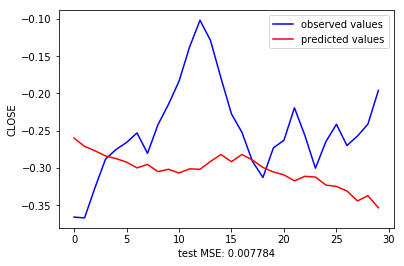

[0.022900586975781834, 0.014466134892412955, 0.012963618838261711, 0.011853984845611181, 0.011608009636944585, 0.01089740455545132, 0.010932668918156755, 0.009376371281100153, 0.00896158138282005, 0.008929940420878123, 0.008067619126331289, 0.008509174958482845, 0.0074793723473533915, 0.00865740260146241, 0.00783494627861216, 0.007292850064496779, 0.007767980405168558, 0.006849637397577421, 0.006335355723688798, 0.00807961194406983, 0.008386181940037703, 0.008992599284180471, 0.006953304481004618, 0.0068979825484314665, 0.005591449623610985, 0.005509927117912282, 0.005084535028886981, 0.004166072870151433, 0.006030965332542999, 0.005929564722583799, 0.004816734524589944, 0.004219844496486138, 0.0036628742526714953, 0.004437336444388921, 0.003461769142538057, 0.0033263038705711873, 0.0028895002463612263, 0.0027765879611388235, 0.0026952124220191317, 0.0023051198838846157, 0.0023119112908789813, 0.0022030483197522186, 0.002191225897173634, 0.002152733585262596, 0.0022210151899843184, 0.0

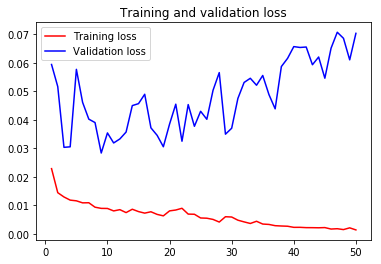

In [257]:
fig_1 = plt.figure(1)
plt.plot(close_values[-30:].T.reshape(30,), color='blue', label='observed values')
plt.plot(predictions, color='red', label='predicted values')

plt.xlabel('test MSE: %f' % test_mse)
plt.ylabel('CLOSE')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

print(loss, val_loss)
fig_2 = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()